In [10]:
import urllib.request
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import os
import math

In [104]:
def get_tiles(url):
    urllib.request.urlretrieve(url,"tile.png")
    tile = np.asarray(Image.open("tile.png"))

    return tile

def get_flood_tiles(x,y,z,e):
    """ 
    :params x,y,z: x and y tiles, z=zoom level
    :param e (f)
    """
    url_flood = f'https://www.floodmap.net/getFMTile.ashx?x={x}&y={y}&z={z}&e={e}'
    return get_tiles(url_flood)

def get_pop_2020_tiles(merc_coord):
    return f'https://sedac.ciesin.columbia.edu/geoserver/wms?service=WMS&request=GetMap&layers=gpw-v4%3Agpw-v4-population-density_2020%2Ccartographic%3A00-global-labels&styles=&format=image%2Fpng&transparent=true&version=1.1.1&width=256&height=256&srs=EPSG%3A3857&bbox={merc_coord[0][1]},{merc_coord[1][0]},{merc_coord[1][1]},{merc_coord[0][0]}'

def get_ssp_tiles(ssp_name,merc_coord):
    return f'https://sedac.ciesin.columbia.edu/geoserver/wms?service=WMS&request=GetMap&layers=popdynamics%3Apopdynamics-pop-projection-ssp-2010-2100_{ssp_name}-total-population%2Ccartographic%3A00-global-labels&styles=&format=image%2Fpng&transparent=true&version=1.1.1&height=256&width=256&srs=EPSG%3A3857&bbox={merc_coord[0][1]},{merc_coord[1][0]},{merc_coord[1][1]},{merc_coord[0][0]}'

def get_image(fp):
    return np.asarray(Image.open(fp))

def tile_num_to_lat_lon(xtile,ytile, zoom):
    """
    :param xtile (int): corresponds to google slippy map tile number
    :param ytile (int): corresponds to google slippy map tile number
    returns the coordinate of the upper left (northwest most) point of the tile,
    and the coordinate of the lower right (south east most) point of tile
    in WGS84 datum
    """
    def num2deg(xtile, ytile, zoom):
      n = 1 << zoom #2**zoom
      lon_deg = xtile / n * 360.0 - 180.0
      lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
      lat_deg = math.degrees(lat_rad)
      return lat_deg, lon_deg
    
    UL = num2deg(xtile, ytile, zoom)
    LR = num2deg(xtile+1, ytile+1, zoom)
    return UL,LR

def lat_lon_to_mercator(coord, R =  6378137.0):
    """ 
    :param coord (tuple): where coord = (UL,LR), 
        UL = (lat_deg, lon_deg) of upper left corner of tile
        LR = (lat_deg, lon_deg) of lower right corner of tile
    """
    def lat2y(lat, R=R):
        return math.log(math.tan(math.pi / 4 + math.radians(lat) / 2)) * R

    def lon2x(lon, R=R):
        return math.radians(lon) * R
    
    UL_wgs = coord[0]
    LR_wgs = coord[1]
    UL_merc = (lat2y(UL_wgs[0]),lon2x(UL_wgs[1]))
    LR_merc = (lat2y(LR_wgs[0]),lon2x(LR_wgs[1]))
    return UL_merc, LR_merc

def save_tiles(tile_list,save_dir,ssp_name=None):
    """ 
    :param tile_list (list of tuples): where each tuple is (x,y,z), where z is the zoom level
    :param ssp_name (str): name of ssp e.g. ssp1-2050
    """
    if ssp_name is None:
        ssp_name = 'population-density_2020'
    ssp_dir = os.path.join(save_dir,ssp_name)
    if not os.path.exists(ssp_dir):
        os.mkdir(ssp_dir)
    for (x,y,z) in tile_list:
        coord = tile_num_to_lat_lon(x,y,z)
        merc_coord = lat_lon_to_mercator(coord)
        if ssp_name == 'population-density_2020':
            url = get_pop_2020_tiles(merc_coord)
        else:
            url = get_ssp_tiles(ssp_name,merc_coord)
        
        tile = get_tiles(url)
        tilename = os.path.join(ssp_dir,f'x-{x}_y-{y}_z-{z}.png')
        print(tilename)
        im = Image.fromarray(tile)
        im.save(tilename)

    return

class FloodSSP:
    def __init__(self, e, ssp_dir, ssp_legend_dict_fp):
        """ 
        :param e (int): elevation of SLR
        :param ssp_dir (str): directory of ssp
        :param
        """
        self.e = e
        self.ssp_dir = ssp_dir
        self.ssp_name = os.path.basename(ssp_dir)
        self.ssp_legend_dict_fp = ssp_legend_dict_fp
        self.legend_dict = None
        if os.path.exists(ssp_legend_dict_fp):
            with open(ssp_legend_dict_fp,'rb') as f:
                legend_dict = pickle.load(f)
            self.legend_dict = legend_dict
            self.legend_dict_px_arr = np.vstack([self.legend_dict[i]['pixel_val'] for i in range(len(self.legend_dict))])
            self.min_popn_legend = np.array([self.legend_dict[i]['min'] for i in range(len(self.legend_dict))]) # min popn count for legend 0 to 11
            self.max_popn_legend = np.array([self.legend_dict[i]['max'] for i in range(len(self.legend_dict))]) # max popn count for legend 0 to 11
            self.legend_dict_px_arr_norm = self.legend_dict_px_arr/np.tile(np.linalg.norm(self.legend_dict_px_arr,axis=1).reshape(-1,1),(1,3))
        else:
            raise IOError
        self.flood_dir = os.path.join(os.path.dirname(ssp_dir),f'flood_{int(e)}')
        self.save_dir = os.path.join(os.path.dirname(ssp_dir),f'{self.ssp_name}_e-{e}')
        

    def get_xyz(self,fn):
        """ 
        :param fn (str): get xyz from filename
        """
        xyz = os.path.splitext(fn)[0]
        x,y,z = [int(i[-1]) for i in xyz.split('_')]
        return x,y,z
    
    def popn_affected(self,save_dir=False):
        """ 
        :param save_dir (bool)
        """
        if not os.path.exists(self.save_dir) and save_dir is True:
            os.mkdir(self.save_dir)
        popn_min = []
        popn_max = []
        for img_fp in os.listdir(self.ssp_dir):
            xyz = os.path.splitext(img_fp)[0]
            x,y,z = [int(i[-1]) for i in xyz.split('_')]
            ssp_fp = os.path.join(self.ssp_dir,img_fp)
            ssp_img = get_image(ssp_fp)
            if os.path.exists(self.flood_dir):
                flood_fp = os.path.join(self.flood_dir,img_fp)
                flood_img = get_image(flood_fp)
            else:
                flood_img = get_flood_tiles(x,y,z,self.e)
            if save_dir is True:
                save_fp = os.path.join(self.save_dir,f'x-{x}_y-{y}_z-{z}.png')
            else:
                save_fp = None
            flooded_extent = self.get_flooded_extent(flood_img,ssp_img,save_fp=save_fp)
            popn = self.calculate_popn_affected(flooded_extent)
            if popn is not None:
                popn_min.append(popn[0])
                popn_max.append(popn[1])
            
        if len(popn_min) > 0:
            return sum(popn_min), sum(popn_max)
        else:
            return None

    def get_flooded_extent(self,flood_img,ssp_img,save_fp=None):
        """ 
        :param save_fp (str)
        """
        assert flood_img.shape[-1] == 4 and ssp_img.shape[-1] == 4 #check that its img with alpha channel
        mask_list = [flood_img[:,:,-1],ssp_img[:,:,-1]]
        mask_list = [(m/255).astype(np.uint8) for m in mask_list]
        flooded_extent_mask = np.multiply(*mask_list)
        flooded_extent_mask = np.repeat(flooded_extent_mask[:,:,np.newaxis],4,axis=2)
        # print(flooded_extent_mask.shape)
        flooded_extent = flooded_extent_mask*ssp_img#[:,:,:3]
        if save_fp is not None:
            im = Image.fromarray(flooded_extent)
            im.save(save_fp)
        return flooded_extent

    def calculate_popn_affected(self,flooded_extent):
        """ 
        :param legend_dict (dict): maps pixel values to popn
        returns estimated min and max population affected
        """
        # use dot matrix to quickly calculate which color palette has the highest dot product value instead of using for loops
        if self.legend_dict is not None:
            flooded_extent = flooded_extent[:,:,:3]
            px_arr, counts = np.unique(flooded_extent.reshape(-1, flooded_extent.shape[2]), axis=0,return_counts=True)
            
            px_arr_norm = px_arr/np.tile(np.linalg.norm(px_arr,axis=1).reshape(-1,1),(1,3))
            if np.sum(px_arr[1,:]) == 0:
                px_arr_norm = px_arr_norm[1:,:] # remove the first row because row 0 is [0,0,0] --> normalisation will lead to NAs
                counts = counts[1:]
            dot_pdt = np.dot(px_arr_norm,self.legend_dict_px_arr_norm.T)
            legend_match = np.argmax(dot_pdt,axis=1) #to see which color palette best matches legend color

            legend_count = np.bincount(legend_match,weights = counts) # frequency of pixels for each legend, outputs the length == max(legend_match), e.g. if 9th legend is the highest, length == 10
            # legend_count outputs the pixel count for each legend
            n_legend_detected = legend_count.shape[0]
            # multiply legend_count by popn count as each legend corresponds to a different population count
            min_popn = np.sum(legend_count * self.min_popn_legend[:n_legend_detected])
            max_popn = np.sum(legend_count * self.max_popn_legend[:n_legend_detected])
            return min_popn, max_popn
        else:
            return None

In [107]:
fssp = FloodSSP(e=1, ssp_dir=r'data\tiles\ssp5-2100', ssp_legend_dict_fp=r'data\ssp\ssp5-2100.ob')
fssp.popn_affected(save_dir=True)

C:\Users\PAKHUIYING\AppData\Local\Temp\ipykernel_2492\1526777246.py:180: RuntimeWarning: invalid value encountered in divide
  px_arr_norm = px_arr/np.tile(np.linalg.norm(px_arr,axis=1).reshape(-1,1),(1,3))


(51411621.0, 101534827.0)

In [113]:
ssp5_2100 = {"x-0_y-1_z-3":"https://live.staticflickr.com/65535/53028209306_2a19e504e5_o.png",
"x-0_y-2_z-3":"https://live.staticflickr.com/65535/53028598055_46d5fc26be_o.png",
"x-0_y-3_z-3":"https://live.staticflickr.com/65535/53028383054_81d4eb4c40_o.png",
"x-1_y-1_z-3":"https://live.staticflickr.com/65535/53028383019_da4a4172da_o.png",
"x-1_y-2_z-3":"https://live.staticflickr.com/65535/53028209286_8891e2632b_o.png",
"x-1_y-3_z-3":"https://live.staticflickr.com/65535/53028209276_a238ea3c10_o.png",
"x-2_y-1_z-3":"https://live.staticflickr.com/65535/53027625147_c84b5d1e55_o.png",
"x-2_y-2_z-3":"https://live.staticflickr.com/65535/53027625142_25c22fdffe_o.png",
"x-2_y-3_z-3":"https://live.staticflickr.com/65535/53028598020_922dc30c3f_o.png",
"x-2_y-4_z-3":"https://live.staticflickr.com/65535/53027625132_31092abb6f_o.png",
"x-2_y-5_z-3":"https://live.staticflickr.com/65535/53028209281_0cb3e182fb_o.png",
"x-3_y-1_z-3":"https://live.staticflickr.com/65535/53028382984_243d97fa3a_o.png",
"x-3_y-2_z-3":"https://live.staticflickr.com/65535/53028382989_bc54d17bfa_o.png",
"x-3_y-3_z-3":"https://live.staticflickr.com/65535/53028695588_a83325726c_o.png",
"x-3_y-4_z-3":"https://live.staticflickr.com/65535/53028597935_6d37e9afd7_o.png",
"x-4_y-1_z-3":"https://live.staticflickr.com/65535/53028209216_a0b4f2e581_o.png",
"x-4_y-2_z-3":"https://live.staticflickr.com/65535/53028597925_cb2eea632b_o.png",
"x-4_y-3_z-3":"https://live.staticflickr.com/65535/53028209146_7e540c5111_o.png",
"x-4_y-4_z-3":"https://live.staticflickr.com/65535/53028209131_057e88f49b_o.png",
"x-5_y-1_z-3":"https://live.staticflickr.com/65535/53028597885_e5083cbf07_o.png",
"x-5_y-2_z-3":"https://live.staticflickr.com/65535/53028209136_83e8b9d39a_o.png",
"x-5_y-3_z-3":"https://live.staticflickr.com/65535/53028695528_f43846c42d_o.png",
"x-5_y-4_z-3":"https://live.staticflickr.com/65535/53027625082_20dc53c3d1_o.png",
"x-6_y-1_z-3":"https://live.staticflickr.com/65535/53028382939_2f14ab785d_o.png",
"x-6_y-2_z-3":"https://live.staticflickr.com/65535/53027625032_f15eb1e7d0_o.png",
"x-6_y-3_z-3":"https://live.staticflickr.com/65535/53028382889_7e6b69bd8d_o.png",
"x-6_y-4_z-3":"https://live.staticflickr.com/65535/53028597850_126701364d_o.png",
"x-7_y-1_z-3":"https://live.staticflickr.com/65535/53028597840_7028956860_o.png",
"x-7_y-2_z-3":"https://live.staticflickr.com/65535/53028382874_8bbab93587_o.png",
"x-7_y-3_z-3":"https://live.staticflickr.com/65535/53028597820_d045b0610b_o.png",
"x-7_y-4_z-3":"https://live.staticflickr.com/65535/53028695453_3bf4b5837c_o.png",
"x-7_y-5_z-3":"https://live.staticflickr.com/65535/53028209066_a9d3bac04c_o.png",
}

global_vulnerability_map = dict()
for xyz in list(ssp5_2100):
    x,y,z = [int(i[-1]) for i in xyz.split('_')]
    UL,LR = tile_num_to_lat_lon(x,y,z)
    global_vulnerability_map[xyz] = {"url": ssp5_2100[xyz], "UL": list(UL), "LR": list(LR)}

with open('data/ssp5-2100_e-1.json',"w") as f:
    json.dump(global_vulnerability_map,f,indent=2)

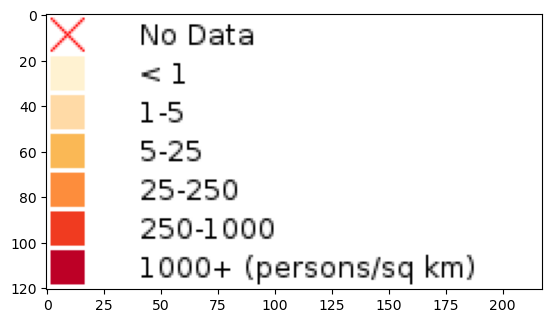

In [56]:
popn_2020_legend = get_tiles('https://sedac.ciesin.columbia.edu/geoserver/ows?service=WMS&request=GetLegendGraphic&format=image/png&width=15&height=15&layer=gpw-v4:gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals_2020&style=gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals_2020:default&')
plt.imshow(popn_2020_legend)

In [58]:
with open('data/mumbai_tiles/mumbai_tiles.ob','rb') as f:
    mumbai_tiles = pickle.load(f)
mumbai_tiles

[(1438, 913, 11),
 (1438, 914, 11),
 (1439, 913, 11),
 (1438, 912, 11),
 (1439, 912, 11)]

In [105]:
with open(r'data\tiles\global_tiles.ob','rb') as f:
    global_tiles = pickle.load(f)
global_tiles

[(2, 5, 3),
 (7, 5, 3),
 (2, 4, 3),
 (3, 4, 3),
 (4, 4, 3),
 (5, 4, 3),
 (6, 4, 3),
 (7, 4, 3),
 (0, 1, 3),
 (0, 2, 3),
 (0, 3, 3),
 (1, 1, 3),
 (1, 2, 3),
 (1, 3, 3),
 (2, 1, 3),
 (2, 2, 3),
 (2, 3, 3),
 (3, 1, 3),
 (3, 2, 3),
 (3, 3, 3),
 (4, 1, 3),
 (4, 2, 3),
 (4, 3, 3),
 (5, 1, 3),
 (5, 2, 3),
 (5, 3, 3),
 (6, 1, 3),
 (6, 2, 3),
 (6, 3, 3),
 (7, 1, 3),
 (7, 2, 3),
 (7, 3, 3)]

In [106]:
for (x,y,z) in global_tiles:
    flood_img = get_flood_tiles(x,y,z,e=1)
    save_fp = os.path.join(r'data\tiles\flood_1',f'x-{x}_y-{y}_z-{z}.png')
    im = Image.fromarray(flood_img)
    im.save(save_fp)

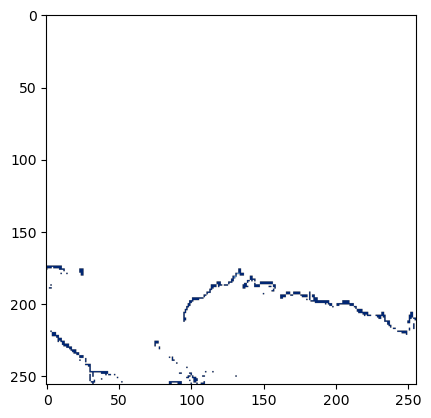

In [81]:
img1 = get_image(r'data\tiles\flood_0\x-0_y-1_z-3.png')
img2 = get_image(r'data\tiles\ssp1-2050\x-0_y-1_z-3.png')

def get_flooded_extent(flood_img,wms_img,save_dir=None):
    assert flood_img.shape[-1] == 4 and wms_img.shape[-1] == 4 #check that its img with alpha channel
    mask_list = [flood_img[:,:,-1],wms_img[:,:,-1]]
    mask_list = [(m/255).astype(np.uint8) for m in mask_list]
    flooded_extent_mask = np.multiply(*mask_list)
    flooded_extent_mask = np.repeat(flooded_extent_mask[:,:,np.newaxis],4,axis=2)
    # print(flooded_extent_mask.shape)
    flooded_extent = flooded_extent_mask*wms_img#[:,:,:3]
    if save_dir is not None:
        im = Image.fromarray(flooded_extent)
        im.save(f'{save_dir}.png')
    return flooded_extent

flooded_extent = get_flooded_extent(img1,img2)

plt.imshow(flooded_extent)

In [73]:
for i in range(1,6):
    for j in [2050,2100]:
        ssp_name = f'ssp{i}-{j}'
        save_tiles(mumbai_tiles,save_dir=r'data\mumbai_tiles',ssp_name=ssp_name)

data\mumbai_tiles\ssp1-2050\x-1438_y-913_z-11.png
data\mumbai_tiles\ssp1-2050\x-1438_y-914_z-11.png
data\mumbai_tiles\ssp1-2050\x-1439_y-913_z-11.png
data\mumbai_tiles\ssp1-2050\x-1438_y-912_z-11.png
data\mumbai_tiles\ssp1-2050\x-1439_y-912_z-11.png
data\mumbai_tiles\ssp1-2100\x-1438_y-913_z-11.png
data\mumbai_tiles\ssp1-2100\x-1438_y-914_z-11.png
data\mumbai_tiles\ssp1-2100\x-1439_y-913_z-11.png
data\mumbai_tiles\ssp1-2100\x-1438_y-912_z-11.png
data\mumbai_tiles\ssp1-2100\x-1439_y-912_z-11.png
data\mumbai_tiles\ssp2-2050\x-1438_y-913_z-11.png
data\mumbai_tiles\ssp2-2050\x-1438_y-914_z-11.png
data\mumbai_tiles\ssp2-2050\x-1439_y-913_z-11.png
data\mumbai_tiles\ssp2-2050\x-1438_y-912_z-11.png
data\mumbai_tiles\ssp2-2050\x-1439_y-912_z-11.png
data\mumbai_tiles\ssp2-2100\x-1438_y-913_z-11.png
data\mumbai_tiles\ssp2-2100\x-1438_y-914_z-11.png
data\mumbai_tiles\ssp2-2100\x-1439_y-913_z-11.png
data\mumbai_tiles\ssp2-2100\x-1438_y-912_z-11.png
data\mumbai_tiles\ssp2-2100\x-1439_y-912_z-11.png


In [ ]:
popn_2020 = [0,1,5,25,250,1000]

In [ ]:
def legend_cmap(legend,ssp_value,save_dir=None):
    legend_c = legend[45:365,7:20,:]
    breaks = len(ssp_value)
    color_range = np.linspace(0,legend_c.shape[0],breaks,dtype=int)
    color_list = []
    fig, axes = plt.subplots(breaks-1,1,figsize=(3,10))
    color_dict = dict()
    for i,ax in zip(range(len(color_range)-1),axes.flatten()):
        legend_slice = legend_c[color_range[i]:color_range[i+1],:,:]
        legend_slice = legend_slice[10:20,:,:]
        legend_slice_mean = np.mean(legend_slice,axis=(0,1)).astype(np.uint8)
        color_list.append(legend_slice_mean)
        ax.imshow(np.tile(legend_slice_mean.reshape(1,1,3),(10,10,1)))
        ax.axis('off')
        ax.set_title(f'{ssp_value[i]} - {ssp_value[i+1]-1}')
        color_dict[i] = {'pixel_val':legend_slice_mean,'min':ssp_value[i],'max':ssp_value[i+1]-1}
    plt.tight_layout()
    plt.show()

    if save_dir is not None:
        fig.savefig(f'{save_dir}.png')
        with open(f'{save_dir}.ob','wb') as f:
            pickle.dump(color_dict,f)
    
    return color_dict

In [59]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import cv2
import math
from scipy import ndimage

In [7]:
ds = gdal.Open('mumbai_land_subsidence_clipped.tif', gdal.GA_ReadOnly)
ulx, xres, xskew, uly, yskew, yres  = ds.GetGeoTransform()
lrx = ulx + (ds.RasterXSize * xres)
lry = uly + (ds.RasterYSize * yres)
rb = ds.GetRasterBand(1)
img_array = rb.ReadAsArray()
img_array.shape

(4246, 3485)

In [30]:
UL = (uly,ulx)
LR = (lry,lrx)
print(UL,LR)

(19.31534, 72.775901) (18.89074, 73.124401)


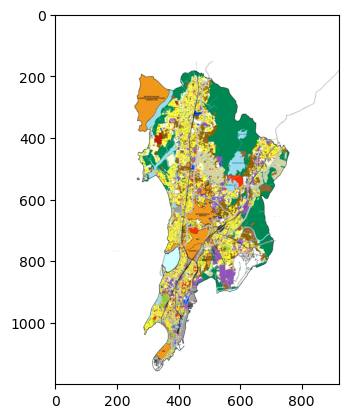

(19.340018, 72.674303) (18.878474, 73.045951)
0.0004039652173913125 0.00038461999999999996


In [31]:
landuse = np.asarray(Image.open(r'layer/all.png'))
plt.figure()
plt.imshow(landuse)
plt.show()

lry_lu = 18.878474
ulx_lu = 72.674303
uly_lu = 19.3400180
lrx_lu = 73.045951

UL_lu = (uly_lu,ulx_lu)
LR_lu = (lry_lu, lrx_lu)
print(UL_lu,LR_lu)
yres_lu = (uly_lu - lry_lu)/landuse.shape[0]
xres_lu = (lrx_lu - ulx_lu)/landuse.shape[1]
print(xres_lu,yres_lu)

4
-3
(4800, 3680, 4)


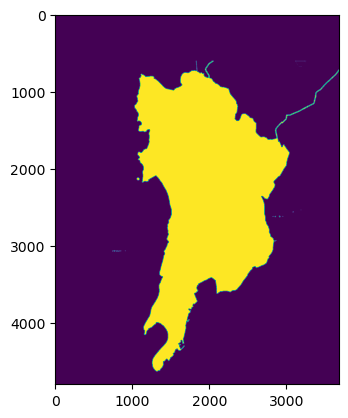

In [42]:
resized_landuse = cv2.resize(landuse, (landuse.shape[1]*int(abs(xres_lu/xres)), landuse.shape[0]*int(abs(xres_lu/xres))), interpolation = cv2.INTER_AREA)
print(int(xres_lu/xres))
print(int(yres_lu/yres))
plt.figure()
plt.imshow(resized_landuse[:,:,-1])
print(resized_landuse.shape)
plt.show()



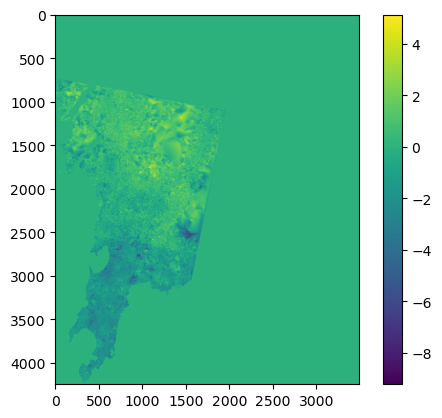

In [6]:

plt.figure()
plt.imshow(img_array)
plt.colorbar()

In [44]:
print(UL, LR, xres, yres)
print(UL_lu, LR_lu, (LR_lu[1] - UL_lu[1])/resized_landuse.shape[1], (UL_lu[0] - LR_lu[0])/resized_landuse.shape[0])

(19.31534, 72.775901) (18.89074, 73.124401) 0.0001000000000000004 -9.999999999999954e-05
(19.340018, 72.674303) (18.878474, 73.045951) 0.00010099130434782813 9.615499999999999e-05


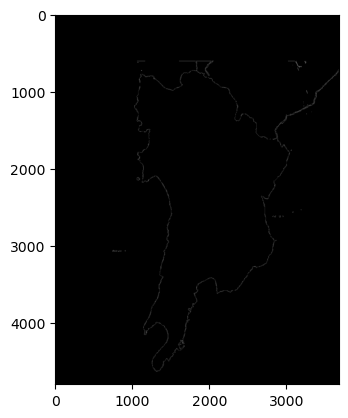

array([0., 1.])

In [66]:
landuse_edge = ndimage.laplace(resized_landuse[:,:,-1])
landuse_edge = np.where(landuse_edge<200,0.0,1.0)
plt.figure()
plt.imshow(landuse_edge,cmap='gray')
plt.show()

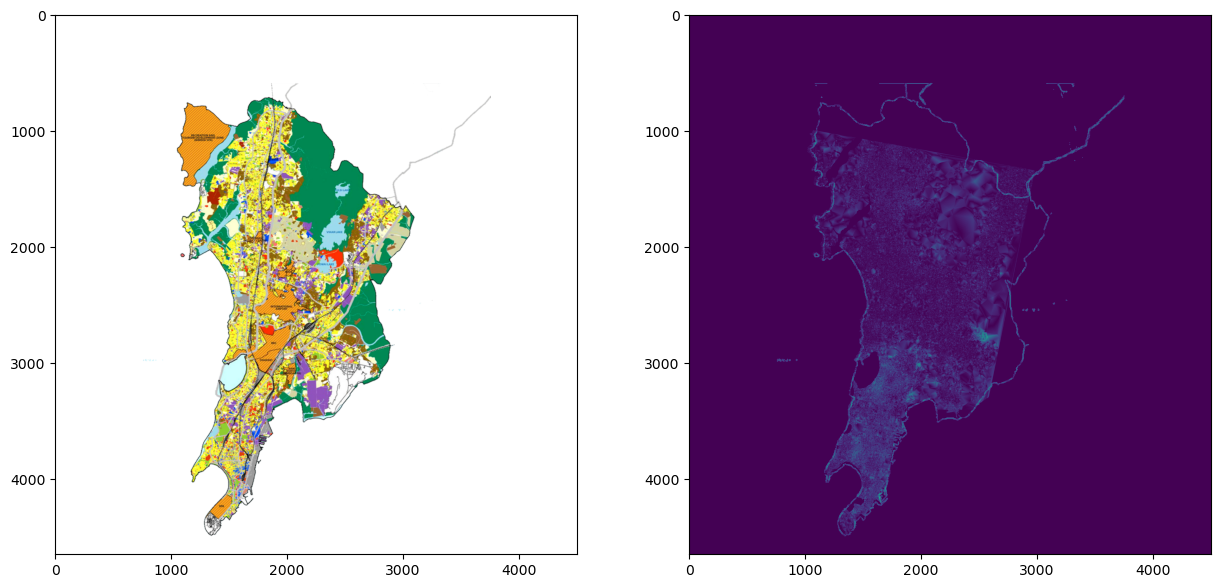

In [98]:
def get_canvas(UL, UL_lu, LR, LR_lu, xres, yres, img,img_lu,w=3680,h=4800):

    img = np.abs(img)
    img = img/np.max(img)
    xres = abs(xres)
    yres = abs(yres)

    n_channel = img_lu.shape[2]
    img_lu = cv2.resize(img_lu, (w,h), interpolation = cv2.INTER_AREA)
    landuse_edge = ndimage.laplace(img_lu[:,:,-1])
    landuse_edge = np.where(landuse_edge<200,0.0,1.0)
    
    max_lat = UL[0] if UL[0] > UL_lu[0] else UL_lu[0]
    min_lat = LR[0] if LR[0] < LR_lu[0] else LR_lu[0]
    max_lon = LR[1] if LR[1] > LR_lu[1] else LR_lu[1]
    min_lon = UL[1] if UL[1] < UL_lu[1] else UL_lu[1]

    nrows = math.ceil((max_lat - min_lat)/yres)
    ncols = math.ceil((max_lon - min_lon)/xres)
    canvas = np.zeros((h,ncols,n_channel))
    canvas_copy =  np.zeros((h,ncols))
    landuse_border = canvas_copy.copy()

    left = int((UL[1] - min_lon)/xres)
    top = int((max_lat - UL[0])/yres)
    right = left + img.shape[1]
    bottom = top + img.shape[0]
    canvas_copy[top:bottom, left:right] = img

    left = int((UL_lu[1] - min_lon)/xres)
    top = int((max_lat - UL_lu[0])/yres)
    right = left + img_lu.shape[1]
    bottom = top + img_lu.shape[0]
    canvas[top:bottom, left:right,:] = img_lu
    landuse_border[top:bottom, left:right] = landuse_edge

    fig, axes = plt.subplots(1,2,figsize=(15,7))
    # ax.imshow(canvas + canvas_copy)
    im = axes[0].imshow(canvas.astype(np.uint8))
    # fig.colorbar(im,ax=axes[0])
    axes[1].imshow(canvas_copy + landuse_border)
    plt.show()
    
    return
get_canvas(UL, (19.34, 72.6741), LR, LR_lu, 
           xres, yres, 
           img_array, landuse,
           w=3750,h=4650)
